[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/romiaprilian7406/sp500-ebitda-margin/blob/main/notebooks/sp500_ebitda_margin_clean.ipynb)

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import RobustScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.covariance import EllipticEnvelope
from sklearn.linear_model import RidgeCV, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Global Configuration

In [2]:
warnings.filterwarnings('ignore')
RANDOM_STATE = 42
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Data Load

In [3]:
dataset_url = 'https://raw.githubusercontent.com/romiaprilian7406/sp500-ebitda-margin/refs/heads/main/data/sp500_ebitda_dataset.csv'

try:
  df = pd.read_csv(dataset_url)
  print(f"Berhasil connect ke {dataset_url}")
except Exception as e:
  print(f"Gagal connect: {e}")

Berhasil connect ke https://raw.githubusercontent.com/romiaprilian7406/sp500-ebitda-margin/refs/heads/main/data/sp500_ebitda_dataset.csv


# EDA

In [4]:
df_eda = df.copy()

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Kolom numerik ({len(num_cols)}): \n{num_cols}")

Kolom numerik (6): 
['revenue', 'revenue_growth', 'total_debt', 'total_cash', 'gross_margin', 'ebitda_margin']


## shape

In [5]:
df_eda.shape

(502, 8)

## info

In [6]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ticker          502 non-null    object 
 1   sector          502 non-null    object 
 2   revenue         502 non-null    int64  
 3   revenue_growth  500 non-null    float64
 4   total_debt      498 non-null    float64
 5   total_cash      502 non-null    float64
 6   gross_margin    502 non-null    float64
 7   ebitda_margin   502 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 31.5+ KB


## head

In [7]:
df_eda.head()

,ticker,sector,revenue,revenue_growth,total_debt,total_cash,gross_margin,ebitda_margin
0,MMM,Industrials,24824999936,0.035,1.365900e+10,5.600000e+09,0.409789,0.248177
1,AOS,Industrials,3830099968,0.044,2.167000e+08,2.396000e+08,0.385134,0.204773
2,ABT,Healthcare,43842998272,0.069,1.502100e+10,7.616000e+09,0.562598,0.267933
3,ABBV,Healthcare,59643998208,0.091,6.714400e+10,5.524000e+09,0.714607,0.494920
4,ACN,Technology,69672976384,0.073,8.182866e+09,1.147873e+10,0.319140,0.175427


## Statistik Deskriptif

In [8]:
df_eda.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
revenue,502.0,3.607808e+10,7.414990e+10,7.723950e+08,6.809425e+09,1.411000e+10,2.904350e+10,7.030610e+11
revenue_growth,500.0,9.896600e-02,2.088305e-01,-4.540000e-01,2.575000e-02,7.300000e-02,1.232500e-01,3.193000e+00
total_debt,498.0,2.005513e+10,4.157584e+10,4.530000e+05,3.474648e+09,8.469321e+09,1.913300e+10,4.543110e+11
total_cash,502.0,7.456578e+09,3.163555e+10,1.326000e+06,5.418695e+08,1.528644e+09,3.966500e+09,4.693170e+11
gross_margin,502.0,4.854477e-01,2.443707e-01,-1.076165e+00,3.197351e-01,4.650812e-01,6.404467e-01,1.000000e+00
ebitda_margin,502.0,2.598775e-01,1.901274e-01,-1.458333e+00,1.432225e-01,2.390565e-01,3.610590e-01,9.242733e-01


## Missing Values

In [9]:
missing = df_eda[num_cols].isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if not missing.empty:
    missing_pct = (missing / len(df_eda)) * 100
    missing_df = pd.DataFrame({'Jumlah Hilang': missing, 'Persentase (%)': missing_pct})
    display(missing_df.style.background_gradient(cmap='Reds', subset=['Persentase (%)']).format("{:.2f}"))
else:
    print("Tidak ditemukan missing values")

,Jumlah Hilang,Persentase (%)
total_debt,4.00,0.80
revenue_growth,2.00,0.40


## Numeric Feature Distribution

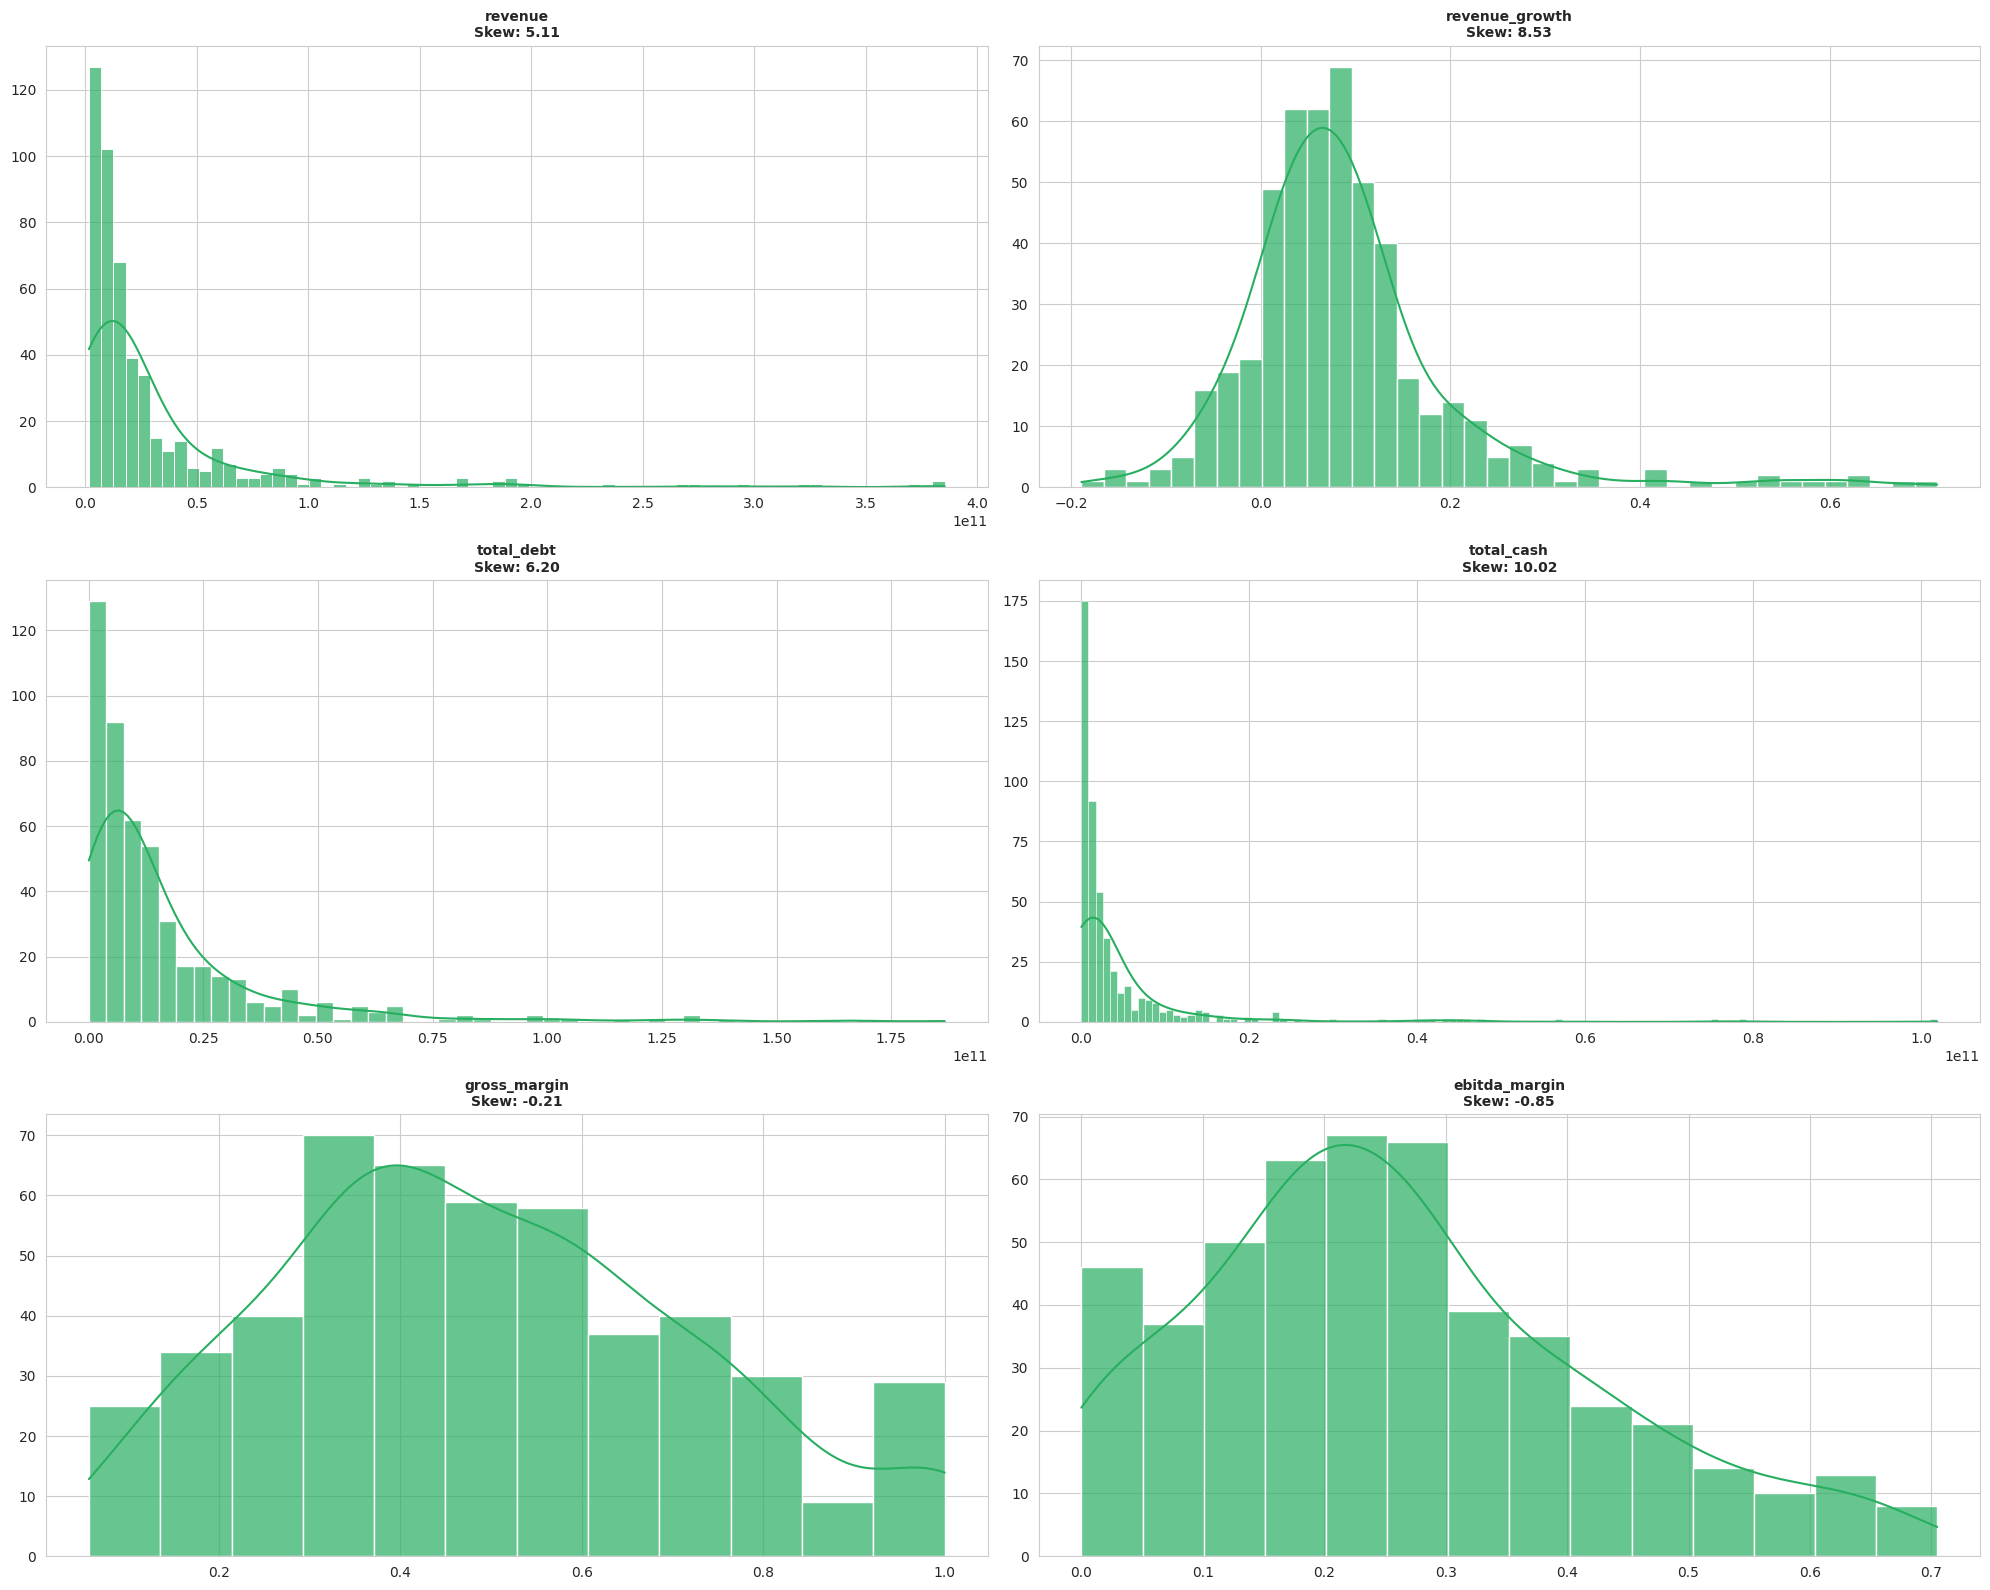

In [10]:
n_cols = 2
n_rows = int(np.ceil(len(num_cols) / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 16))
axs = axs.flatten()

for i, col in enumerate(num_cols):
    data_viz = df_eda[col].dropna()
    q_low, q_high = data_viz.quantile(0.01), data_viz.quantile(0.99)
    data_viz = data_viz[(data_viz >= q_low) & (data_viz <= q_high)]

    sns.histplot(data_viz, kde=True, ax=axs[i], color='#27ae60', alpha=0.7)

    # Skewness Asli
    skew_val = df_eda[col].skew()
    axs[i].set_title(f'{col}\nSkew: {skew_val:.2f}', fontsize=10, fontweight='bold')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

## Outliers

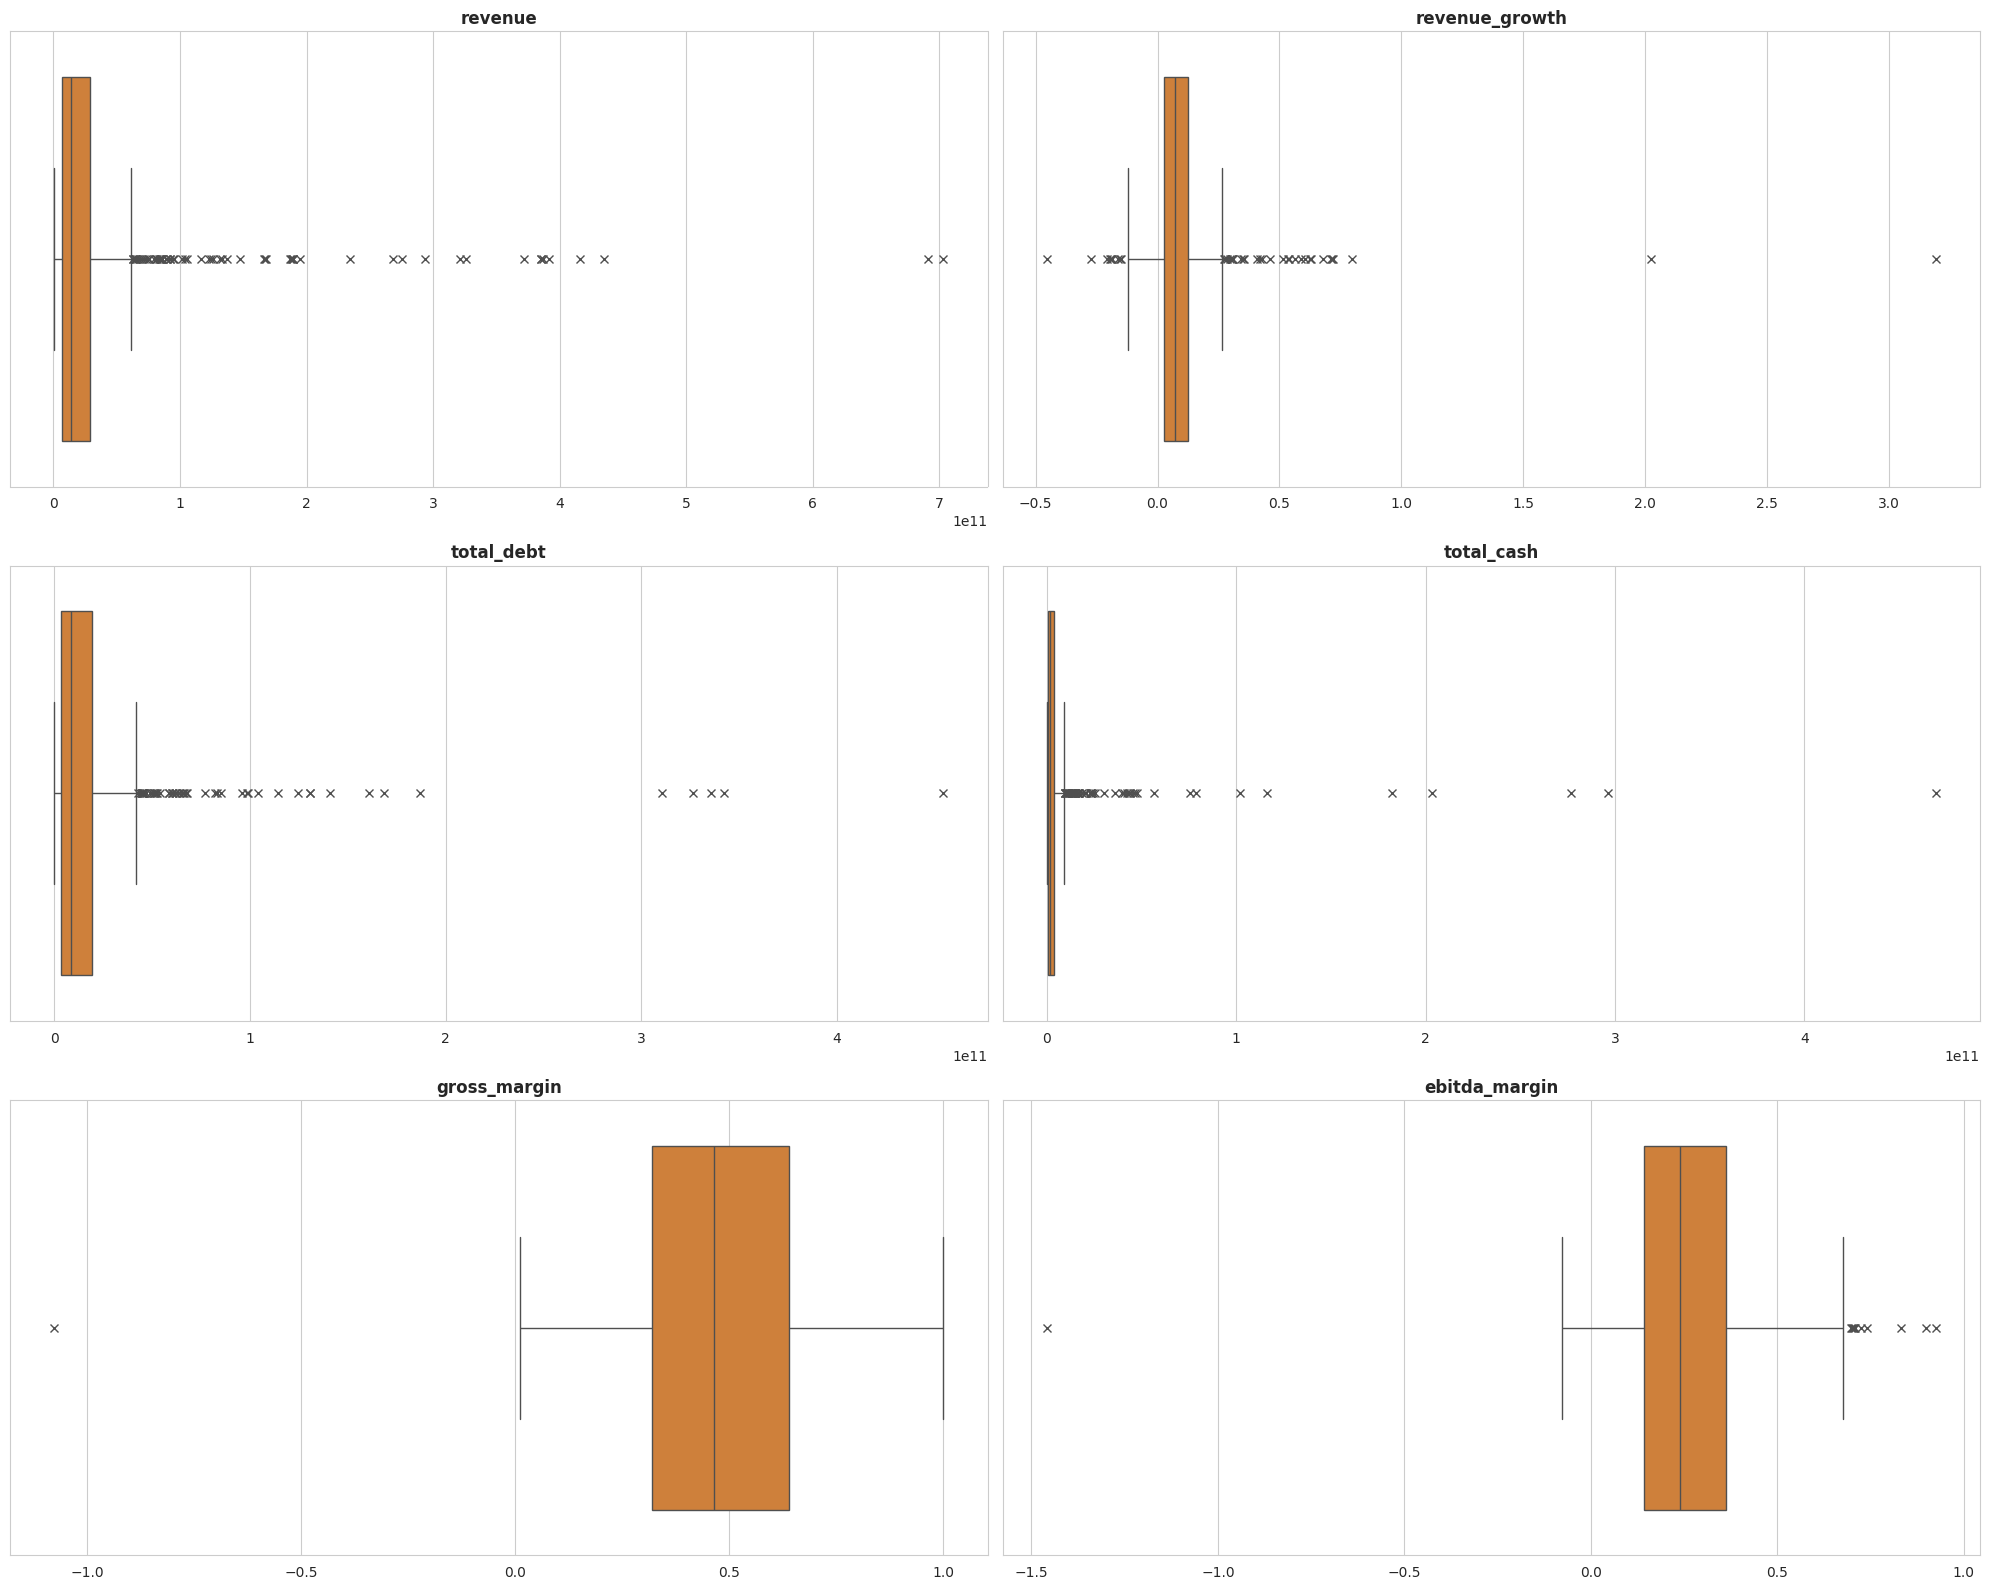


Kepadatan outlier:


,Jumlah Outlier,Persentase (%)
Fitur,,
revenue,63.00,12.55
total_cash,60.00,11.95
total_debt,53.00,10.56
revenue_growth,40.00,7.97
ebitda_margin,11.00,2.19
gross_margin,1.00,0.20


In [11]:
# Metode IQR 1.5x

# 1. Visualisasi (Boxplot)
n_cols = 2
n_rows = int(np.ceil(len(num_cols) / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 16))
axs = axs.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x=df_eda[col], ax=axs[i], color='#e67e22', flierprops={"marker": "x"})
    axs[i].set_title(col, fontweight='bold')
    axs[i].set_xlabel('')

for j in range(i + 1, len(axs)): fig.delaxes(axs[j])
plt.tight_layout()
plt.show()

# 2. Analisis statistik (Ranking)
print("\nKepadatan outlier:")

outlier_stats = []

for col in num_cols:
    # IQR
    Q1 = df_eda[col].quantile(0.25)
    Q3 = df_eda[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Outlier
    n_outliers = ((df_eda[col] < lower_bound) | (df_eda[col] > upper_bound)).sum()
    pct_outliers = (n_outliers / len(df_eda)) * 100

    outlier_stats.append({
        'Fitur': col,
        'Jumlah Outlier': n_outliers,
        'Persentase (%)': pct_outliers
    })

outlier_df = pd.DataFrame(outlier_stats)
outlier_df = outlier_df.sort_values(by='Persentase (%)', ascending=False).set_index('Fitur')

if not outlier_df.empty:
    display(outlier_df.style.background_gradient(cmap='Reds', subset=['Persentase (%)']).format("{:.2f}"))
else:
    print("Tidak ditemukan outlier yang signifikan")

## Correlation Heatmap

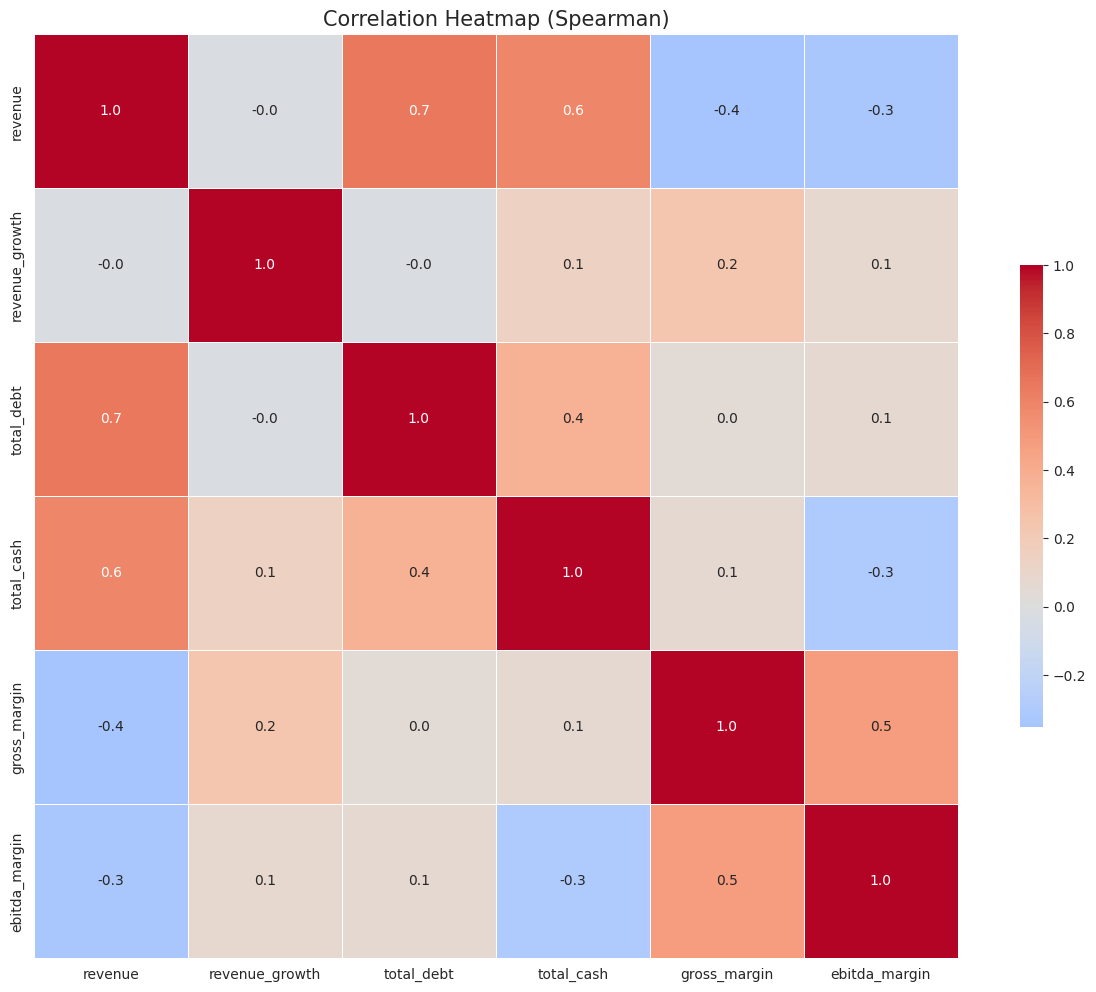

In [12]:
plt.figure(figsize=(16, 12))
corr = df_eda[num_cols].corr(method='spearman')

sns.heatmap(
    corr,
    annot=True,
    fmt=".1f",
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.5}
)
plt.title('Correlation Heatmap (Spearman)', fontsize=15)
plt.show()

# Business Logic Filters

In [13]:
# Fundamental business logic filters
def business_logic_filters(df):
    original_len = len(df)

    # 1. Filter Logika: Pemeriksaan Rasionalitas
    # - EBITDA tidak boleh melebihi Gross Margin (Logika akuntansi)
    # - Margin > 2% (Hapus perusahaan zombie)
    # - Margin < 70% (Hapus outlier perusahaan holding)
    df_clean = df[
        (df['ebitda_margin'] <= df['gross_margin']) &
        (df['ebitda_margin'] > 0.02) &
        (df['ebitda_margin'] < 0.70)
    ].copy()

    # 2. Imputation (Standard Domain Practice)
    df_clean['total_debt'] = df_clean['total_debt'].fillna(0)
    df_clean['revenue_growth'] = df_clean['revenue_growth'].fillna(df_clean['revenue_growth'].median())

    # 3. Feature Engineering (Financial Ratios)
    df_clean['log_revenue'] = np.log1p(df_clean['revenue'])
    df_clean['debt_to_revenue'] = df_clean['total_debt'] / df_clean['revenue']

    print(f"Original Data: {original_len}")
    print(f"Cleaned Data : {len(df_clean)} (Removed {original_len - len(df_clean)} domain outliers)")

    return df_clean

df_eng = business_logic_filters(df)

Original Data: 502
Cleaned Data : 440 (Removed 62 domain outliers)


# Preprocessing

In [14]:
# Define Features & Target
features = ['gross_margin', 'log_revenue', 'debt_to_revenue', 'sector']
target = 'ebitda_margin'

X = df_eng[features]
y = df_eng[target]

# Stratified Split by Sector
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=X['sector']
)

print(f"Train Shape: {X_train.shape}")
print(f"Test Shape : {X_test.shape}")

Train Shape: (352, 4)
Test Shape : (88, 4)


In [15]:
# Penghapusan Outlier Statistik (Hanya Data Latih)

# Detect outliers using EllipticEnvelope (Robust Covariance)
# Menghapus 10% titik data paling "tidak biasa" (anomali)
detector_features = ['gross_margin', 'ebitda_margin', 'debt_to_revenue']
detector = EllipticEnvelope(contamination=0.10, random_state=RANDOM_STATE)

# Fit and predict on Training Data
# Gabungkan X dan y sementara untuk deteksi multivariat (agar hubungan antara fitur dan target juga diperiksa)
train_data_combined = pd.concat([X_train, y_train], axis=1)
outliers = detector.fit_predict(train_data_combined[detector_features])

# Filter Training Data
X_train_clean = X_train[outliers == 1].copy()
y_train_clean = y_train[outliers == 1].copy()

print(f"Training Data (Post-Cleaning): {len(X_train_clean)}")
print(f"Outliers Removed: {len(X_train) - len(X_train_clean)}")

Training Data (Post-Cleaning): 316
Outliers Removed: 36


# Modeling

In [16]:
# Model Architecture: Hybrid Stacking

# A. Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), [f for f in features if f != 'sector']),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['sector'])
    ])

# B. Base Learners
# 1. Ridge (Polynomial)
base_ridge = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('model', RidgeCV(alphas=[0.1, 1.0, 10.0]))
])

# 2. Random Forest (Constrained)
base_rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=5,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=RANDOM_STATE
)

# 3. Gradient Boosting
base_gb = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    random_state=RANDOM_STATE
)

# C. Meta Learner (Stacking)
# HuberRegressor is used as the meta-learner
stacking_model = StackingRegressor(
    estimators=[
        ('ridge', base_ridge),
        ('rf', base_rf),
        ('gb', base_gb)
    ],
    final_estimator=HuberRegressor(epsilon=1.35),
    cv=5,
    n_jobs=-1
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', stacking_model)
])

# Training & Prediction

In [17]:
# Train the model on cleaned training data
pipeline.fit(X_train_clean, y_train_clean)

# Predict on Train (Cleaned) and Test
y_pred_train = pipeline.predict(X_train_clean)
y_pred_test_raw = pipeline.predict(X_test)

# Rule: Predicted EBITDA Margin cannot exceed Actual Gross Margin
y_pred_test_sys = np.minimum(y_pred_test_raw, X_test['gross_margin'])

# Evaluation Metrics & Report

In [18]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return [mae, rmse, r2]

# Calculate Metrics
train_metrics = calculate_metrics(y_train_clean, y_pred_train)
test_metrics = calculate_metrics(y_test, y_pred_test_sys)

df_metrics = pd.DataFrame(
    [train_metrics, test_metrics],
    columns=['MAE', 'RMSE', 'R2'],
    index=['Train (Cleaned)', 'Test (System)']
)

print("Model Performance Report")
display(df_metrics.round(4))

# Verdict Logic
r2_test = df_metrics.loc['Test (System)', 'R2']
mae_test = df_metrics.loc['Test (System)', 'MAE']

Model Performance Report


,MAE,RMSE,R2
Train (Cleaned),0.0420,0.0553,0.8229
Test (System),0.0507,0.0669,0.8068


# Visualization

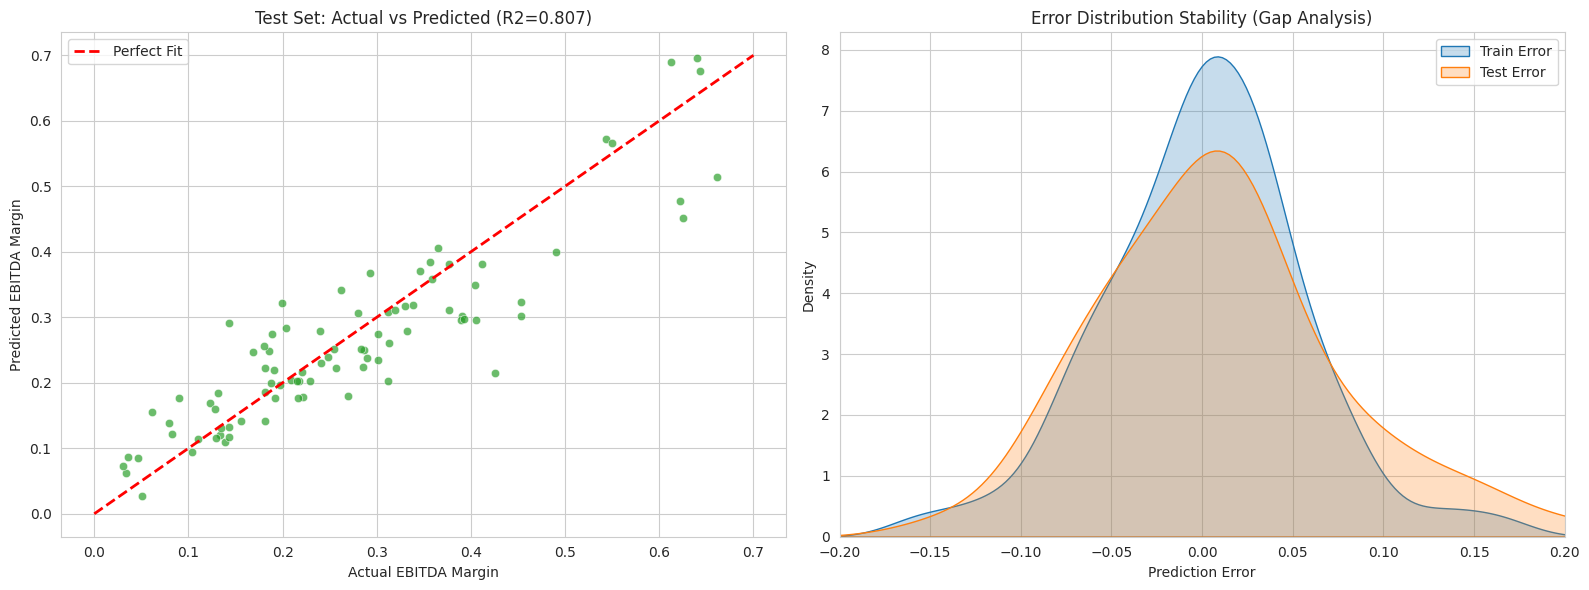

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Actual vs Predicted (Test Set)
sns.scatterplot(x=y_test, y=y_pred_test_sys, alpha=0.7, color='#2ca02c', ax=axes[0])
# Perfect Prediction Line
min_val, max_val = 0, 0.7
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
axes[0].set_title(f'Test Set: Actual vs Predicted (R2={df_metrics.loc["Test (System)", "R2"]:.3f})', fontsize=12)
axes[0].set_xlabel('Actual EBITDA Margin')
axes[0].set_ylabel('Predicted EBITDA Margin')
axes[0].legend()

# Plot 2: Error Distribution
train_error = y_train_clean - y_pred_train
test_error = y_test - y_pred_test_sys

sns.kdeplot(train_error, label='Train Error', fill=True, color='#1f77b4', ax=axes[1])
sns.kdeplot(test_error, label='Test Error', fill=True, color='#ff7f0e', ax=axes[1])
axes[1].set_title('Error Distribution Stability (Gap Analysis)', fontsize=12)
axes[1].set_xlabel('Prediction Error')
axes[1].set_xlim(-0.2, 0.2)
axes[1].legend()

plt.tight_layout()
plt.show()

# Model Interpretability & Explainability

Meta-Learner Architecture Analysis


,Base Model,Weight (Trust Level)
2,Grad. Boost (Tree),0.567984
0,Ridge (Linear),0.538451
1,Random Forest (Tree),-0.111544


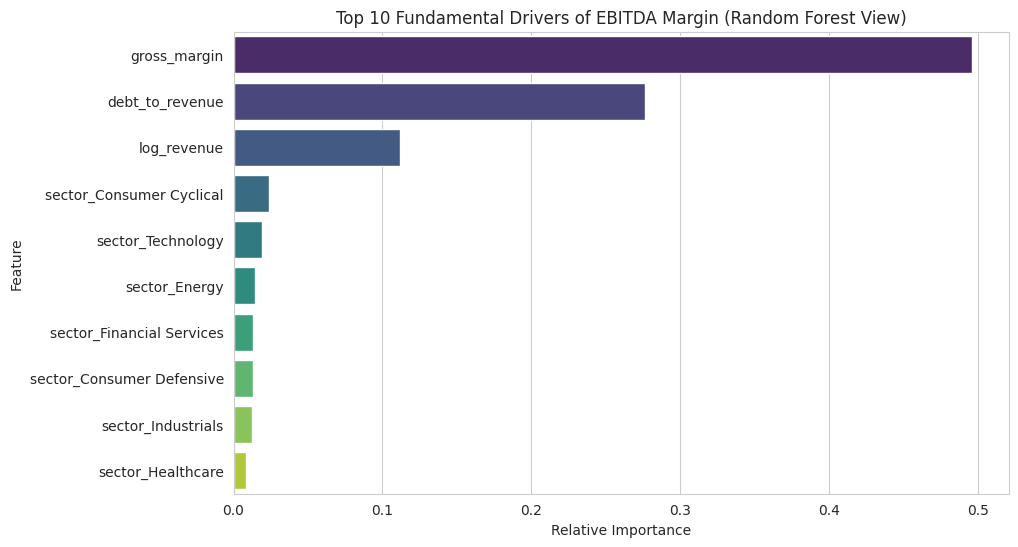

In [20]:
# A. Meta-Learner Weights
# Mengambil bobot dari HuberRegressor
meta_model = pipeline.named_steps['model'].final_estimator_
base_model_names = ['Ridge (Linear)', 'Random Forest (Tree)', 'Grad. Boost (Tree)']
meta_weights = meta_model.coef_

df_meta = pd.DataFrame({
    'Base Model': base_model_names,
    'Weight (Trust Level)': meta_weights
}).sort_values(by='Weight (Trust Level)', ascending=False)

print("Meta-Learner Architecture Analysis")
display(df_meta)

# B. Feature Importance (Dari Random Forest Base Learner)
rf_model = pipeline.named_steps['model'].estimators_[1] # Index 1 is RF based on our definition
feature_names = num_cols = [f for f in features if f != 'sector']
# Get OneHotEncoder feature names
ohe = preprocessor.named_transformers_['cat']
feature_names.extend(ohe.get_feature_names_out(['sector']))

importances = rf_model.feature_importances_
df_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

# Visualisasi
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_imp, palette='viridis')
plt.title('Top 10 Fundamental Drivers of EBITDA Margin (Random Forest View)')
plt.xlabel('Relative Importance')
plt.show()

# Investment Strategy

In [21]:
# Screening: Finding Undervalued Efficiency

# 1. Predict on FULL Dataset (All companies, not just Test set)
# Screening peluang di seluruh pasar
X_full = df_eng[features]
y_pred_full_raw = pipeline.predict(X_full)
y_pred_full_sys = np.minimum(y_pred_full_raw, df_eng['gross_margin'])

# 2. Create Analysis DataFrame
df_results = df_eng.copy()
df_results['Predicted_Margin'] = y_pred_full_sys
df_results['Efficiency_Alpha'] = df_results['Predicted_Margin'] - df_results['ebitda_margin']

# 3. Define Strategy Signals
# - Positive Alpha: Model bilang margin harusnya TINGGI, tapi realita RENDAH (Potensi Turnaround/Inefficiency)
# - Negative Alpha: Model bilang margin harusnya RENDAH, tapi realita TINGGI (Management Overperformance/Moat)

top_turnaround_candidates = df_results.sort_values(by='Efficiency_Alpha', ascending=False).head(10)
top_moat_candidates = df_results.sort_values(by='Efficiency_Alpha', ascending=True).head(10)

print("TOP 10 'TURNAROUND' CANDIDATES (Potential Undervalued)")
print("Perusahaan ini memiliki margin aktual JAUH DI BAWAH potensi fundamentalnya")
display(top_turnaround_candidates[['ticker', 'sector', 'gross_margin', 'ebitda_margin', 'Predicted_Margin', 'Efficiency_Alpha']].style.background_gradient(subset=['Efficiency_Alpha'], cmap='Greens'))

print("\nTOP 10 'MOAT' CANDIDATES (Management Superstars)")
print("Perusahaan ini memiliki margin aktual JAUH DI ATAS prediksi model (Punya keunggulan unik)")
display(top_moat_candidates[['ticker', 'sector', 'gross_margin', 'ebitda_margin', 'Predicted_Margin', 'Efficiency_Alpha']].style.background_gradient(subset=['Efficiency_Alpha'], cmap='Reds_r'))

TOP 10 'TURNAROUND' CANDIDATES (Potential Undervalued)
Perusahaan ini memiliki margin aktual JAUH DI BAWAH potensi fundamentalnya


,ticker,sector,gross_margin,ebitda_margin,Predicted_Margin,Efficiency_Alpha
139,DAY,Technology,0.509217,0.058892,0.221230,0.162338
53,AXON,Industrials,0.603566,0.027834,0.190036,0.162202
65,XYZ,Technology,0.411183,0.069643,0.221320,0.151677
259,IRM,Real Estate,0.556328,0.336443,0.484321,0.147877
178,EL,Consumer Defensive,0.741728,0.143431,0.290947,0.147516
494,WDAY,Technology,0.756364,0.131080,0.275718,0.144638
377,PFG,Financial Services,0.465894,0.137683,0.278706,0.141023
313,MGM,Consumer Cyclical,0.446462,0.133869,0.263078,0.129209
99,CVX,Energy,0.406016,0.199712,0.321956,0.122244
417,SOLV,Healthcare,0.544037,0.149845,0.270898,0.121052



TOP 10 'MOAT' CANDIDATES (Management Superstars)
Perusahaan ini memiliki margin aktual JAUH DI ATAS prediksi model (Punya keunggulan unik)


,ticker,sector,gross_margin,ebitda_margin,Predicted_Margin,Efficiency_Alpha
123,CPRT,Industrials,0.476236,0.425390,0.214282,-0.211108
21,MO,Consumer Defensive,0.721859,0.625211,0.451599,-0.173611
468,VRSN,Technology,0.879695,0.696687,0.523656,-0.173030
333,NEM,Basic Materials,0.592987,0.569641,0.404631,-0.165010
196,FSLR,Technology,0.400477,0.399697,0.239463,-0.160234
276,KLAC,Technology,0.612952,0.449267,0.294462,-0.154805
34,ADI,Technology,0.614669,0.453222,0.302001,-0.151220
129,CTRA,Energy,0.747675,0.661116,0.513653,-0.147463
36,APA,Energy,0.665422,0.621907,0.476857,-0.145050
471,VRTX,Healthcare,0.527164,0.401918,0.259147,-0.142771


# Export Model

In [23]:
model_name = 'sp500_ebitda_model.joblib'
joblib.dump(pipeline, model_name)

print(f"Model successfully saved as: {model_name}")

Model successfully saved as: sp500_ebitda_model.joblib
